In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open('./data/flowers_cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes('./data/flowers/train/')
print(classes)
print(c_2_idx)
print()
cls_2_name = {}
idx_2_fld = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    cls_2_name[int(cls)] = cat_to_name[str(k)]
    idx_2_fld[int(cls)] = str(k)
print(cls_2_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [3]:
train_data_path = "./data/flowers/train"

# Note transforms.ToTensor() scales input images
# to 0-1 range

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225] )
    ])

"""
img_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
"""

train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

val_data_path = "./data/flowers/valid"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = None 

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

print(('load data ---> done!'))

load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
102


torch.Size([3, 224, 224])
tensor([ 60,  90,  24,  49,  81,  55,  54,  23,  64,  96,  97,  75,  78,  57,
         66,  74,  32,  84,  24,  98,   5,  43,  37,  90,  73,  66, 100,  97,
         27,  57,  54,  76])


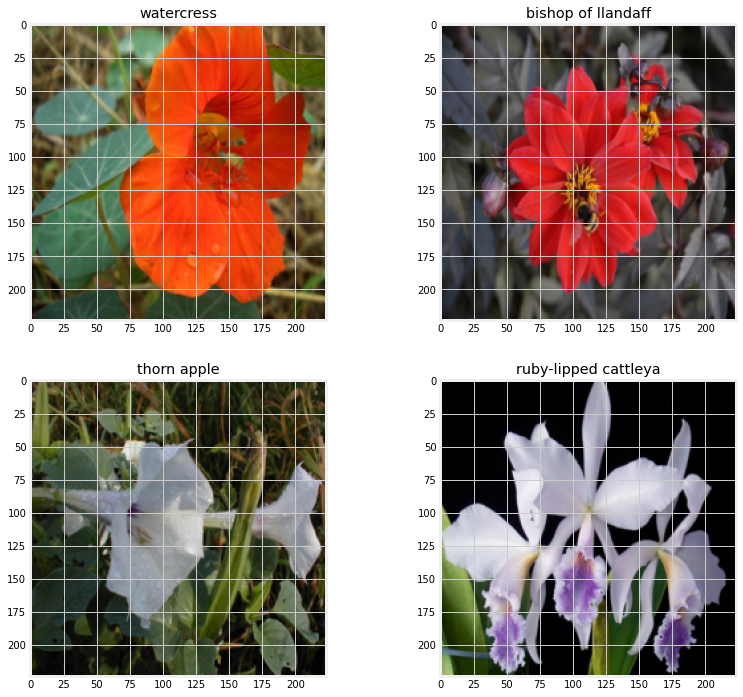

In [8]:
# Get one batch

dt,target = next(iter(train_data_loader))

print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
axes[0,1].imshow(dt[6].numpy().transpose(1, 2, 0))
axes[0,1].title.set_text(cls_2_name[int(target[6].numpy())])
axes[1,0].imshow(dt[11].numpy().transpose(1, 2, 0))
axes[1,0].title.set_text(cls_2_name[int(target[11].numpy())])
axes[1,1].imshow(dt[16].numpy().transpose(1, 2, 0))
axes[1,1].title.set_text(cls_2_name[int(target[16].numpy())])
plt.show()

In [15]:
################################
# network PnasNet
################################

class SepConv(nn.Module):
    '''Separable Convolution.'''
    def __init__(self, in_planes, out_planes, kernel_size, stride):
        super(SepConv, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes,
                               kernel_size, stride,
                               padding=(kernel_size-1)//2,
                               bias=False, groups=in_planes)
        self.bn1 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        return self.bn1(self.conv1(x))


class CellA(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(CellA, self).__init__()
        self.stride = stride
        self.sep_conv1 = SepConv(in_planes, out_planes, kernel_size=7, stride=stride)
        if stride==2:
            self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
            self.bn1 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        y1 = self.sep_conv1(x)
        y2 = F.max_pool2d(x, kernel_size=3, stride=self.stride, padding=1)
        if self.stride==2:
            y2 = self.bn1(self.conv1(y2))
        return F.relu(y1+y2)

class CellB(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(CellB, self).__init__()
        self.stride = stride
        # Left branch
        self.sep_conv1 = SepConv(in_planes, out_planes, kernel_size=7, stride=stride)
        self.sep_conv2 = SepConv(in_planes, out_planes, kernel_size=3, stride=stride)
        # Right branch
        self.sep_conv3 = SepConv(in_planes, out_planes, kernel_size=5, stride=stride)
        if stride==2:
            self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
            self.bn1 = nn.BatchNorm2d(out_planes)
        # Reduce channels
        self.conv2 = nn.Conv2d(2*out_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        # Left branch
        y1 = self.sep_conv1(x)
        y2 = self.sep_conv2(x)

        # Right branch
        y3 = F.max_pool2d(x, kernel_size=3, stride=self.stride, padding=1)

        if self.stride==2:
            y3 = self.bn1(self.conv1(y3))

        y4 = self.sep_conv3(x)

        # Concat & reduce channels
        b1 = F.relu(y1+y2)
        b2 = F.relu(y3+y4)

        y = torch.cat([b1,b2], 1)
        z = F.relu(self.bn2(self.conv2(y)))
        return z

class PNASNet(nn.Module):
    def __init__(self, cell_type, num_cells, num_planes, num_classes):
        super(PNASNet, self).__init__()
        self.in_planes = num_planes
        self.cell_type = cell_type

        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_planes)

        self.layer1 = self._make_layer(num_planes, num_cells=num_cells)
        self.layer2 = self._downsample(num_planes*2)
        self.layer3 = self._make_layer(num_planes*2, num_cells=num_cells)
        self.layer4 = self._downsample(num_planes*4)
        self.layer5 = self._make_layer(num_planes*4, num_cells=num_cells)
        self.linear = nn.Linear(num_planes*4, num_classes)

    def _make_layer(self, planes, num_cells):
        layers = []
        for _ in range(num_cells):
            layers.append(self.cell_type(self.in_planes, planes, stride=2))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def _downsample(self, planes):
        layer = self.cell_type(self.in_planes, planes, stride=2)
        self.in_planes = planes
        return layer

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PNASNetA():
    return PNASNet(CellA, num_cells=6, num_planes=44)

def PNASNetB():
    return PNASNet(CellB, num_cells=6, num_planes=32)


#net = PNASNet(CellB, num_cells=1, num_planes=4, num_classes=num_classes)
#x = torch.randn(1,3,224,224)
#y = net(x)
#print(y.size())

In [9]:
model = PNASNet(CellB, num_cells=1, num_planes=4, num_classes=num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 102])


In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        
        print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [11]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training model

In [ ]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=10, device=device)

---- Training ----


### Test

In [30]:
test_data_path = "./data/flowers/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms)

batch_size=32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 2.19, accuracy = 0.31


tensor([ 5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11])
tensor([15,  2,  2, 15,  3, 15,  3, 12, 15,  3,  8,  2,  8,  8,  2,  8,  2,  2,
         2,  8, 15,  2,  2,  9,  2, 10,  2,  2,  2, 16,  2,  8])


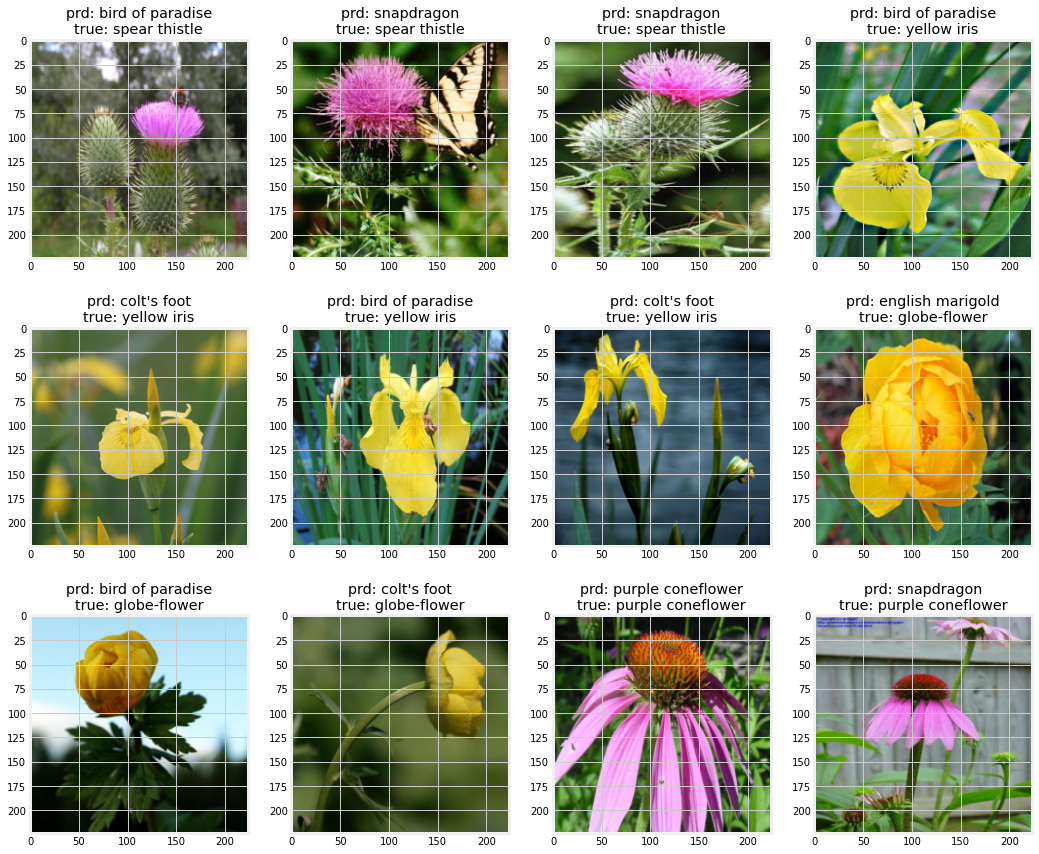

In [32]:
it = iter(test_loader)
it.next()
dt, labs = it.next()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

plt.figure(figsize=(16,15))
k = 0
for i in range(3):
    for j in range(4):
        ax = plt.subplot2grid((3,4), (i,j))
        #print(dt[k].numpy().transpose((1, 2, 0)).shape)
        tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + '\ntrue: ' + cls_2_name[int(labs[k].numpy())]
        ax.imshow(dt[k].numpy().transpose((1, 2, 0)))
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()